In [48]:
!pip uninstall -y -q pyarrow
!pip install -q ray[debug]

     |████████████████████████████████| 23.1MB 72.5MB/s 
     |████████████████████████████████| 2.9MB 43.7MB/s 
     |████████████████████████████████| 133kB 50.6MB/s 
     |████████████████████████████████| 1.3MB 38.7MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 204kB 49.6MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 143kB 50.6MB/s 
     |████████████████████████████████| 296kB 49.5MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 


In [84]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import pandas as pd
import time
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import os
from functools import partial


In [46]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
data_path= pd.read_csv('/content/gdrive/My Drive/Computer vision Term Paper/A_Z Handwritten Data.csv')

## These are the hyperparameters


In [ ]:
#hyperparameters

bs =200
nb_epochs = 3
num_of_images = 60
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

In [ ]:
path_to_download = '/Users/carlairismao/Documents/NTU masters 2020-21/AI6121 Computer Vision/Term Paper'

In [ ]:
train = datasets.MNIST(path_to_download, download=True, train=True, transform=transform)
validation = datasets.MNIST(path_to_download, download=True, train=False, transform=transform)
load_train = torch.utils.data.DataLoader(train, batch_size=5000, shuffle=True)
load_val = torch.utils.data.DataLoader(validation, batch_size=5000, shuffle=True)

Extracting /Users/carlairismao/Documents/NTU masters 2020-21/AI6121 Computer Vision/Term Paper/MNIST/raw/train-images-idx3-ubyte.gz to /Users/carlairismao/Documents/NTU masters 2020-21/AI6121 Computer Vision/Term Paper/MNIST/raw


Extracting /Users/carlairismao/Documents/NTU masters 2020-21/AI6121 Computer Vision/Term Paper/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/carlairismao/Documents/NTU masters 2020-21/AI6121 Computer Vision/Term Paper/MNIST/raw


Extracting /Users/carlairismao/Documents/NTU masters 2020-21/AI6121 Computer Vision/Term Paper/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/carlairismao/Documents/NTU masters 2020-21/AI6121 Computer Vision/Term Paper/MNIST/raw


Extracting /Users/carlairismao/Documents/NTU masters 2020-21/AI6121 Computer Vision/Term Paper/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/carlairismao/Documents/NTU masters 2020-21/AI6121 Computer Vision/Term Paper/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)





Done!


In [ ]:
data_iter = iter(load_train)
data, labels = data_iter.next()
print(data.shape)
print(labels.shape)


torch.Size([5000, 1, 28, 28])
torch.Size([5000])


label tensor(4)


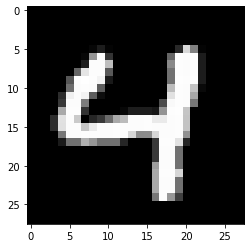

In [ ]:
plt.imshow(data[2].numpy().squeeze(), cmap='gray');
print("label", labels[2])

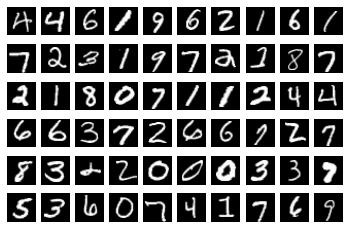

In [ ]:
figure = plt.figure()
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(data[index].numpy().squeeze(), cmap='gray')

In [70]:
class neural_net(nn.Module):
  def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
    super(neural_net, self).__init__()

    self.layer1 = nn.Linear(input_size, hidden_size1, bias = True)
    self.layer2 = nn.Linear(hidden_size1, hidden_size2, bias = True)
    self.layer3 = nn.Linear(hidden_size2, output_size, bias = True)


  def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z  = self.layer2(y_hat)
        z_hat = torch.relu(z)
        scores = self.layer3(z_hat)
        
        return scores

In [ ]:
net = neural_net(input_size, hidden_sizes[0], hidden_sizes[1], output_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()

optimizer=torch.optim.SGD( net.parameters() , lr=0.01 )


In [ ]:
data, labels = next(iter(load_train))
data = data.view(data.shape[0], -1)

In [ ]:
scores = net(data) #log probabilities
probs= torch.softmax(scores, dim=1)
loss = criterion(probs, labels) #calculate the NLL loss

In [ ]:
print(loss)

tensor(2.3036, grad_fn=<NllLossBackward>)


In [ ]:
#print('Before backward pass: \n', net[0].weight.grad)
#loss.backward()
#print('After backward pass: \n', net[0].weight.grad)

In [ ]:
start = time.time()

for epoch in range(200):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(5000)
 
    for count in range(0,5000,bs):
        
        # forward and backward pass
    
        optimizer.zero_grad()
        
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  data[indices]
        minibatch_label= labels[indices]

        inputs = minibatch_data.view(bs,784)

        inputs.requires_grad_()

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label) 
        
        loss.backward()

        optimizer.step()
        
        
        # compute some stats
        
        running_loss += loss.detach().item()
               
        #error = utils.get_error( scores.detach() , minibatch_label)
       # error = 
        #running_error += error.item()
        
        num_batches+=1
    
    
    # once the epoch is finished we divide the "running quantities"
    # by the number of batches
    
    total_loss = running_loss/num_batches
    #total_error = running_error/num_batches
    elapsed_time = time.time() - start
    
    # every 10 epoch we display the stats 
    # and compute the error rate on the test set  
    
    if epoch % 5 == 0 : 
       
        
        print('epoch=',epoch, '\t time=', elapsed_time,
              '\t loss=', total_loss  ,'percent')
        
        #eval_on_test_set()
               

epoch= 0 	 time= 0.09928774833679199 	 loss= 0.3044484603404999 percent
epoch= 5 	 time= 0.5768513679504395 	 loss= 0.2939891666173935 percent
epoch= 10 	 time= 1.0639533996582031 	 loss= 0.28453474104404447 percent
epoch= 15 	 time= 1.5545377731323242 	 loss= 0.27695181369781496 percent
epoch= 20 	 time= 2.0247786045074463 	 loss= 0.2679736638069153 percent
epoch= 25 	 time= 2.508615732192993 	 loss= 0.25970142126083373 percent
epoch= 30 	 time= 2.987720012664795 	 loss= 0.25284973710775377 percent
epoch= 35 	 time= 3.4758949279785156 	 loss= 0.24719861626625061 percent
epoch= 40 	 time= 3.9705393314361572 	 loss= 0.24037853956222535 percent
epoch= 45 	 time= 4.45297384262085 	 loss= 0.2338781851530075 percent
epoch= 50 	 time= 4.944355487823486 	 loss= 0.22865342497825622 percent
epoch= 55 	 time= 5.426531076431274 	 loss= 0.2232656556367874 percent
epoch= 60 	 time= 5.908841609954834 	 loss= 0.21692101895809174 percent
epoch= 65 	 time= 6.400299549102783 	 loss= 0.21218734741210937 

In [ ]:
#optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)
optimizer=torch.optim.SGD( net.parameters() , lr=0.01 )

start = time.time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for data, labels in load_train:
        # Flatten MNIST images into a 784 long vector
        data = data.view(data.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = net(data)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(load_train)))
#print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.26929504921038944
Epoch 1 - Training loss: 0.26609064390261966
Epoch 2 - Training loss: 0.26376426592469215
Epoch 3 - Training loss: 0.2615535420676072
Epoch 4 - Training loss: 0.2598080113530159
Epoch 5 - Training loss: 0.25808260093132657
Epoch 6 - Training loss: 0.256620613237222
Epoch 7 - Training loss: 0.255266555895408
Epoch 8 - Training loss: 0.2539602480828762
Epoch 9 - Training loss: 0.25278351207574207
Epoch 10 - Training loss: 0.25177022193868953
Epoch 11 - Training loss: 0.25053034846981365
Epoch 12 - Training loss: 0.24944124246637026
Epoch 13 - Training loss: 0.24849237129092216
Epoch 14 - Training loss: 0.24757121006647745


In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 7


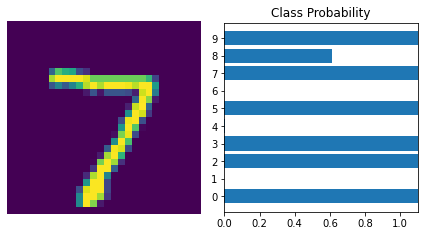

In [ ]:
data, labels = next(iter(validation))

img = data[0].view(1, 784)
with torch.no_grad():
    logps = net(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [ ]:
correct_count, all_count = 0, 0
for data,labels in load_val:
  for i in range(len(labels)):
    img = data[i].view(1, 784)
    with torch.no_grad():
        logps = net(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))


Number Of Images Tested = 10000

Model Accuracy = 0.93


In [ ]:
test_data = 
test_label = 

In [ ]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,2000,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        inputs = minibatch_data.view(bs,784)

        scores=net( inputs ) 

        #error = utils.get_error( scores , minibatch_label)

        #running_error += error.item()

        num_batches+=1


    #total_error = running_error/num_batches
    #print( 'test error  = ', total_error*100 ,'percent')

In [ ]:
test = datasets.MNIST(path_to_download, download=True, train=True, transform=transform)
validation = datasets.MNIST(path_to_download, download=True, train=False, transform=transform)
load_train = torch.utils.data.DataLoader(train, batch_size=5000, shuffle=True)
load_val = torch.utils.data.DataLoader(validation, batch_size=5000, shuffle=True)

# New Method, Tuning hyperparameters

In [66]:
config = {
    "hidden_layer1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "hidden_layer2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "bs": tune.choice([32,64,128,192,256])
}

In [68]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [72]:
def load_data(data_dir="./data"):

    transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                  ])
    #train_set = datasets.MNIST(path_to_download, download=True, train=True, transform=transform)
    #test_set = datasets.MNIST(path_to_download, download=True, train=False, transform=transform)
    
    
    train_set = torchvision.datasets.MNIST(
        root=data_dir, train=True, download=True, transform=transform)

    test_set = torchvision.datasets.MNIST(
        root=data_dir, train=False, download=True, transform=transform)


    #load_train = torch.utils.data.DataLoader(train, batch_size=5000, shuffle=True)
    #load_val = torch.utils.data.DataLoader(validation, batch_size=5000, shuffle=True)

    return train_set, test_set

In [73]:
class network(nn.Module):
  def __init__(self, hidden_size1, hidden_size2):
    super(neural_net, self).__init__()

    self.layer1 = nn.Linear(784, hidden_size1, bias = True)
    self.layer2 = nn.Linear(hidden_size1, hidden_size2, bias = True)
    self.layer3 = nn.Linear(hidden_size2, 10, bias = True)


  def forward(self, x):
        
        y = self.layer1(x)
        y_hat = torch.relu(y)
        z = self.layer2(y_hat)
        z_hat = torch.relu(z)
        scores = self.layer3(z_hat)
        
        return scores

In [64]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [78]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    train_set, test_set = load_data(data_dir)

    test_abs = int(len(train_set) * 0.8)
    train_subset, val_subset = random_split(
        train_set, [test_abs, len(train_set) - test_abs])

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [80]:
def test_accuracy(net, device="cpu"):
    train_set, test_set = load_data()

    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [ ]:
def main(num_samples=60, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=60, max_num_epochs=10, gpus_per_trial=0)

2020-11-14 10:58:50,938	WARNING experiment.py:274 -- No name detected on trainable. Using DEFAULT.
2020-11-14 10:58:50,939	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 3.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2/2 CPUs, 0/0 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects
Result logdir: /root/ray_results/DEFAULT_2020-11-14_10-58-50
Number of trials: 1/60 (1 RUNNING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_60ed3_00000 | RUNNING  |       |            4 |    4 |    4 | 0.000250216 |
+---------------------+----------+-------+--------------+------+------+-------------+


